# Midterm 2 - Andrew Schwartz - PHYS 403, SPR 2024

## 1. Bump Hunting

An experiment searches for a new particle, the $X$ particle, with unknown mass $m_X$. The experiment selects candidate events as a function of the measured mass. There is a background that is known to be flat over the mass range of interest. Assume that any signal due to the $X$ particle has a Gaussian shape, but with unknown width. It is reasonable to assume that the width is relatively narrow, not more than a few GeV. Neither the signal nor the background rate is known. 

The experimental data are plotted below, and can be downloaded from Blackboard in the file $\texttt{bump_hunt.txt}$. You may assume that there are no systematic uncertainties, and that the statistics are sufficiently high that the uncertainty on the number of counts in a bin is approximately Gaussian with $\sigma = \sqrt{N}$ where $N$ is the number of counts.
 
Determine the significance of the signal, using any reasonable analysis technique. Justify any assumptions you make. Report some quantitative measure of the significance (i.e. compared to a model with only background), report an estimator of the mass $m_X$ and estimate its uncertainty. 

Hint: Fit the data with a function that has a flat background term added to a Gaussian signal term, with the normalization, the location parameter, and the scaling parameter free. For the null hypothesis, fit the data with only a flat background and no signal term.
 
This problem is deliberately open-ended. You may use either Bayesian or frequentist techniques. You can earn full points as long as your analysis and its interpretation is correct, and any assumptions are reasonable and justified. There are several correct approaches, and you may choose any one of them. You may (but are not required to) pursue multiple approaches, and comment on the advantages and/or disadvantages. 

Warning: four-dimensional minimization and integration is not fast. It is possible that you will encounter calculations that take a long time (hours) to complete. You may comment on this in your interpretation

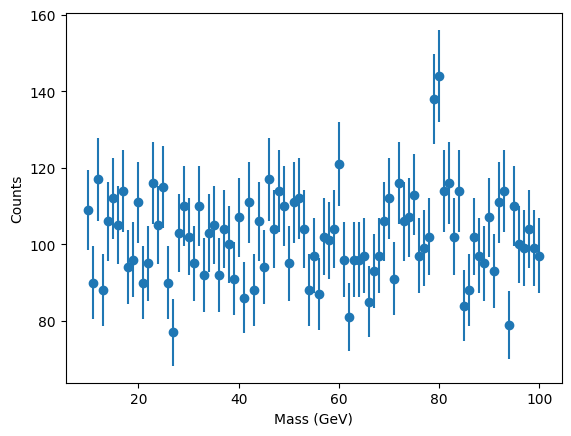

In [156]:
# just getting stuff set up

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm as gaussian, chi2 as chi2dist
from prettytable import PrettyTable

def load():
    # sorry if this is very long, my editor has an option to collapse the string so I don't see it 
    d = np.fromstring("""10 109 
11 90 
12 117 
13 88 
14 106 
15 112 
16 105 
17 114 
18 94 
19 96 
20 111 
21 90 
22 95 
23 116 
24 105 
25 115 
26 90 
27 77 
28 103 
29 110 
30 102 
31 95 
32 110 
33 92 
34 103 
35 105 
36 92 
37 104 
38 100 
39 91 
40 107 
41 86 
42 111 
43 88 
44 106 
45 94 
46 117 
47 104 
48 114 
49 110 
50 95 
51 111 
52 112 
53 104 
54 88 
55 97 
56 87 
57 102 
58 101 
59 104 
60 121 
61 96 
62 81 
63 96 
64 96 
65 97 
66 85 
67 93 
68 97 
69 106 
70 112 
71 91 
72 116 
73 106 
74 107 
75 113 
76 97 
77 99 
78 102 
79 138 
80 144 
81 114 
82 116 
83 102 
84 114 
85 84 
86 88 
87 102 
88 97 
89 95 
90 107 
91 93 
92 111 
93 114 
94 79 
95 110 
96 100 
97 99 
98 104 
99 99 
100 97""", dtype=float, sep=' ')
    N = len(d) // 2
    mass, counts = d.reshape(N, 2).T
    return N, mass, counts, np.sqrt(counts)


N, xs, ys, dys = load()


def data_fig(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.errorbar(xs, ys, dys, fmt='o')
    ax.set(
        xlabel='Mass (GeV)',
        ylabel='Counts'
    )


data_fig()
plt.show()

## Solution

Using $x_i$ as mass and $y_i$ as count with uncertainty $\sigma_i$.

Define the background $$B(x|b)=b$$ where $b$ is the background number of counts. 
 
Define the signal 
$$ S(x|A,μ,σ)=A e^{-\frac{(x-\mu)^2}{2\sigma^2} $$
where $A$ is the normalization (set the scale of how far from the background the Gaussian goes), $\mu$ is the center mass of the spike, and $\sigma$ is the width of the spike.

With these functions we define our null hypothesis $M_0$ with the function $f(x|M_0)=B(x|b)$ and the discovery hypothesis $M_1$ with the function $f(x|M_1)=B(x|b)+S(x|A,\mu,\sigma)$.

This lets us fit the models by minimizing a $chi^2$ test statistic given by
$$ \chi^2_{M_i}=\sum_{i=1}^N \left(\frac{y_i-f(x_i)}{\sigma_i}\right)^2 $$
where $f$ is either the background or the background+signal.

In [158]:
# our background model: just some constant background `b` independent of mass xᵢ
background = lambda b, x: b

# signal: an arbitrarily `nor`malized Gaussian centered at `loc` with width `scale`
signal = lambda norm, loc, scale, x: norm * gaussian.pdf(x, loc=loc, scale=scale)

# our full model: background + signal
full = lambda b, norm, loc, scale, x: background(b, x) + signal(norm, loc, scale, x)

# M[0] and M[1]
models = [background, full]

In [198]:
# a function that, for the given model function `f` will calculate χ² for a given set of parameters
chi2 = lambda f: lambda ps: np.sum((ys - f(*ps, xs)) ** 2 / dys ** 2)

# explanations of parameter range choices:
# (I originally probably had a reason for them to be linspaces but idk now, and it would take a bit of time to refactor)
# let the background be anywhere in the range of recorded counts
bs = np.linspace(np.min(ys), np.max(ys), 1000)
# good guess for possible normalization (height) of Gaussian, 
#  want it to be at least the std dev (~20), and just picked some big number for max
norms = np.linspace(20, 500, 1000)
# let the signal be anywhere in the range of measured masses
locs = np.linspace(*xs[[0, -1]], 1000)
# let the scale (width) of the Gaussian be "a few GeV" as the problem said
scales = np.linspace(0, 5, 1000)
print(scales[[0, -1]])

# (lower, upper) bound for each fitting parameter
bounds = [ls[[0, -1]] for ls in (bs, norms, locs, scales)]

# find the best value of `b` for M₀
best_background = minimize(chi2(background), 0, bounds=[bounds[0]]).x

# find the best parameters for M₁,
best_full_res = minimize(
    chi2(full), [*best_background, 30, 80, 2],
    method='Nelder-Mead',
    bounds=bounds
)
print(best_full_res)
best_full = best_full_res.x

models_fit = list(zip(models, [best_background, best_full]))

[0. 5.]
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 86.68241981868678
             x: [ 1.000e+02  1.039e+02  7.970e+01  8.550e-01]
           nit: 183
          nfev: 316
 final_simplex: (array([[ 1.000e+02,  1.039e+02,  7.970e+01,  8.550e-01],
                       [ 1.000e+02,  1.039e+02,  7.970e+01,  8.550e-01],
                       ...,
                       [ 1.000e+02,  1.039e+02,  7.970e+01,  8.550e-01],
                       [ 1.000e+02,  1.039e+02,  7.970e+01,  8.550e-01]]), array([ 8.668e+01,  8.668e+01,  8.668e+01,  8.668e+01,
                        8.668e+01]))


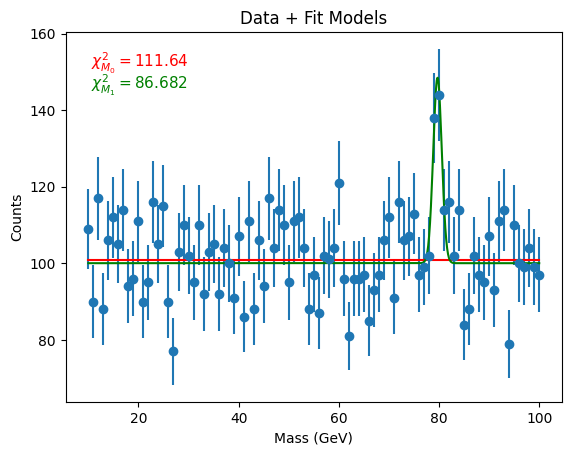

In [199]:
fig, ax = plt.subplots()
data_fig(ax)

colors = ["red", "green"]
for (model, params), color in zip(models_fit, colors):
    ax.plot(locs, [model(*params, mass) for mass in locs], color=color)

# calculate chi2 for each model with the best fit params
chi2s = [chi2(model)(params) for model, params in models_fit]
for i, χ2 in enumerate(chi2s):
    ax.text(
        0.05, 0.95 - 0.06 * i,
        f'$\chi^2_{{M_{i}}}={χ2:.5}$',
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment='top', horizontalalignment='left',
        color= colors[i]
        # bbox={'facecolor': 'white', 'alpha': 0.5, 'boxstyle': 'round'}
    )
    
plt.title("Data + Fit Models")
plt.show()

See how similar the constant background terms for the two models are:

In [182]:
best_full[0] - best_background[0]

-0.8673341922151252

In [177]:
# n params, then 1 arg is `x`
n_params = lambda f: f.__code__.co_argcount - 1
# the p value is 1 - cdf(χ²,dof=N-(# fit params))
p_vals = [chi2dist.sf(chi2, N - n_params(model)) for chi2, model in zip(chi2s, models)]

Since the models are nested, we have 
$$ 
\begin{align}
\Delta\chi^2 &\sim \chi_{M_1}^2-\chi_{M_0}^2 \\
    &=\chi_{4-1}^2 \\
    &=\chi_3^2.
\end{align}
$$

Thus, we can determine the $p$-value of the $\Delta\chi^2$:

In [178]:
deltaChi2 = chi2s[0] - chi2s[1]
p_delta = chi2dist.sf(deltaChi2, 3)

In [179]:
t = PrettyTable(["", "Model 0 (null)", "Model 1 (signal)", "Δ=M₁-M₀"], float_format=".6")
t.add_row(["χ²", *chi2s, deltaChi2])
t.add_row(["p-val", *p_vals, p_delta])
print(t)

+-------+----------------+------------------+-----------+
|       | Model 0 (null) | Model 1 (signal) |  Δ=M₁-M₀  |
+-------+----------------+------------------+-----------+
|   χ²  |   111.636636   |    86.682420     | 24.954216 |
| p-val |    0.060834    |     0.489438     |  0.000016 |
+-------+----------------+------------------+-----------+


Both the null and signal hypotheses have reasonable $p$-values. Comparing at the difference $\Delta\chi^2$ for the two models compared to a $chi_3^2$ distribution, we get a very small $p$-value of $1.6e-5$. This means that the signal hypothesis is able to fit the data much better than might be expected for an increase by 3 fitting parameters. 

This tells us that, despite the slightly increased complexity of the signal model $M_1$, it increases the fit enough that we should favor it to conclude that the particle $X$ exists.

Our estimate of $m_X$ is the location of the best fit params for $M_1$, with the uncertainty the width parameter:

In [205]:
print(f"m_X = {best_full[2]:.4}±{best_full[3]:.4}")

m_X = 79.7±0.855
